# Sequence mapping and clustering

A common need in bioinformatics is, given a number of *query* sequences, group them based on their similarity either to one another, or their similarity to sequences in an external reference database, or to both. The most common way to do this is using sequence alignment (you may be noticing a theme here...).

The process of searching a set of sequences against a reference database to find their best match is typically referred to a **sequence mapping**. One example of this would be in *genome re-sequencing*. If you're searching for polymorphisms in the human genome that may be associated with a phenotype (e.g., a particular disease) you might begin by sequencing the full human genome. Because the human genome has been fully sequenced and (mostly) assembled, you could map your short sequence reads against the full human genome, and then search for loci (or co-located sets of one or more bases) that vary with the phenotype of interest. Because this process is generally performed with DNA sequencing reads, you may also hear it referred to as *read mapping*.

A similar process can be applied if there is no reference database to search against. In this case, sequences will be grouped together based on their similarity to one another. This is most often applied to reads of a single gene or locus across the genomes of many different organisms. This process is referred to as **de novo sequence clustering**, and one field where this is common is **microbiomics**, or the study of whole communities of microorganisms. Because we don't know how to culture the vast majority of microbes, most of what we know about the composition of microbial communities (e.g., in free-living environments, such as the ocean, soil, or surfaces in our homes or offices, or in host-associated environments, such as the human gut) is based on sequencing specific marker genes such as the 16S rRNA from all community members. If we obtain a large number of sequence reads, many of the things we want to do with them (such as identify their taxonomic origin, or understand where they fall in a phylogenetic tree) is too computationally intensive to achieve. So instead, we group sequences that are identicial or highly similar in composition into **Operational Taxonomic Units (OTUs)**, and we choose a single representative of that OTU to work with downstream. For example, if we have a group of 16S rRNA reads that are within 97% identity to one member of that cluster (the cluster centroid) we may assume that the taxonomic origin of the cluster centroid is the same as the taxonomic origin of all of the sequences in the group. This is an *assumption* - it may or may not be true - but it is a necessary evil given the current technology. 

Another application of grouping similar sequences (or **OTU clustering**, or **OTU picking**, as it is sometimes referred to) is in grouping sequences in a database before investigating them, to reduce taxonomic bias in the database. For example, *E. coli* is one of the most heavily sequenced microbes. If you're interested in understanding the frequency of variants of a specific gene across a range of microbial diversity, you might begin by obtatining all sequences of that gene from [GenBank](https://www.ncbi.nlm.nih.gov/genbank/). Because there may be many more *E. coli* sequences, purely because of sequencing bias, you'd likely want to group your sequences into OTUs before computing variant frequencies, so your calculations are not biased toward the frequencies in *E. coli*, as hundreds of E. coli sequences would likely group to one or a few closely related OTUs. In other words, you're trying to find a **divergent set** of sequences to work with (and an [aptly named tool](http://www.ncbi.nlm.nih.gov/pubmed/16769708) was published in 2006 to automate this process).

We have learned the key tools we need for both sequence mapping and clustering in previous chapters. **Because the process of read mapping is nearly identical to database searching, in this chapter we'll start by exploring how to perform de novo sequence clustering**. At the end of the chapter we'll look at a case where we combine sequence clustering with sequence mapping, which arose to deal with massive sequence datasets generated in microbiomics.

In [1]:
%pylab inline

from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
import pandas as pd
from skbio import BiologicalSequence, DNA, Alignment
from skbio.alignment import SequenceCollection
from skbio.parse.sequences import parse_fasta
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide

Populating the interactive namespace from numpy and matplotlib


## *De novo* clustering of sequences by similarity 

The algorithm at the core of *de novo* clustering is sequence alignment. In an ideal world, we would perform a full multiple sequence alignment of all of our sequences, compute their pairwise similarities (or dissimilarities), and use those values to group sequences that are above some *similarity threshold* into *OTU clusters* (just *OTUs* from here). As we discussed in the mutliple sequence alignment chapter however, that is infeasible for more than a few tens of sequences due to computational and memory requirements. Even progressive alignment can't typically handle more than a few tens of thousands of sequences (at least with the currently available implementations, that I am aware of), so OTU clustering is generally acheived by picking pairs of sequences to align. You'll notice in this section that many of the heuristics that have been applied for speeding up database searching are similar to the heuristics applied for OTU clustering.

We'll work with SSW for Smith-Waterman pairwise alignment with affine gap scoring here, though in principle any pairwise aligner could be substituted. 

In the figures that follow, points (or nodes) represent sequences, and line (or edges) connecting points indicate that a pair of sequences are within a defined percent identity threshold. These illustrations are used to describe OTUs, such that a set of points that are connected either directly or indirecty represent a grouping of sequences into an OTU.

Let's define a collection of sequences to work with. These are derived from the [Greengenes](http://greengenes.secondgenome.com/) [13_8](ftp://greengenes.microbio.me/greengenes_release/gg_13_5/) database, and we're pulling them from the [QIIME default reference project](https://github.com/biocore/qiime-default-reference). We can load these as a list of sequences using ``skbio.parse.sequences.parse_fasta``, and count them by taking the length of the list. For the sake of runtime, we'll work with only a small random subset these sequences.

**Our goal here will be to group these sequences into OTUs based on some similarity threshold that we define.** If we set this similarity threshold at 70%, meaning that the sequences within that OTU are 70% identicial (either to each other, or maybe to some representative of that cluster - we'll explore some variants on that definition below), we'd call these *70% OTUs*.  

In [2]:
from qiime_default_reference import get_reference_sequences 
from random import random

seqs_16s = []
fraction_to_keep = 0.001
for e in list(parse_fasta(get_reference_sequences())):
    if random() < fraction_to_keep:
        seqs_16s.append(BiologicalSequence(e[1], id=e[0]))
seqs_16s = SequenceCollection(seqs_16s)
print(seqs_16s.sequence_count())

99


### Furthest neighbor clustering

The first approach we'll look at is one that has been called *furthest neighbor*, because whether a sequence becomes a member of a cluster is defined by it's most dissimilar (furthest) "neighbor" in that cluster.

The way this algorithm works is that we start with our list of sequences. Because this is *de novo* clustering, by definition our first sequence is added to a new cluster (because there are no pre-existing clusters). We'll call this `OTU 1`. We then iterate over the remaining sequences. For the second sequence we compute its pairwise alignment with the first, followed by computing their percent similarity. If their percent similarity is greater than or equal to the similarity threshold, we add the second sequence to `OTU 1`. If is it less than the similarity threshold, we create a new OTU, `OTU 2`, and add the second sequence to that cluster. 

We continue iterating over the remaining sequences. For each sequence, we compute the pairwise similarity between that sequence and all sequences in each OTU. **If the percent similarity between a query sequence and *all* sequences in a given OTU (say OTU $x$ is greater than the similarity threshold, we add the sequence to OTU $x$.)** Otherwise we check the next OTU in the list. If this criteria is not met for any of the OTUs, then we define a new OTU to add the sequence to. 

Let's implement this, and then try it out on some test sequences.

In [3]:
from numpy import mean
from functools import partial            

def cluster(seqs, similarity_threshold, cluster_fn, aligner=local_pairwise_align_ssw, verbose=False):
    clusters = []
    num_alignments = 0
    for query_seq in seqs:
        if verbose: print(query_seq.id)
        clustered = False
        for i, cluster in enumerate(clusters, start=1):
            if verbose: print(" OTU %d" % i)
            clustered, alignment_results = cluster_fn(
                query_seq, cluster, similarity_threshold, aligner, verbose=verbose)
            num_alignments += len(alignment_results)
            if clustered:
                break
        if clustered:
            for n, s in alignment_results:
                cluster.add_edge(query_seq, n, percent_similarity=s)
                # this is very inefficient, but need a way to retain order
                # for centroid clustering.
                # will come back to this...
                cluster.graph['node-order'].append(query_seq)
            if verbose: print("Added to OTU")
        else:
            # create a new cluster containing only this node
            new_cluster = nx.Graph(id="OTU %d" % (len(clusters) + 1))
            new_cluster.add_node(query_seq)            
            # this is very inefficient, but need a way to retain order
            # for centroid clustering.
            # will come back to this...
            new_cluster.graph['node-order'] = [query_seq]
            clusters.append(new_cluster)
            if verbose: print("Created OTU")
    return clusters, num_alignments


def furthest_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    for node in cluster.nodes_iter():
        aln = aligner(seq, node)
        percent_similarity = aln[0].fraction_same(aln[1])
        alignment_results.append((node, percent_similarity))
        if verbose: print("  ", node.id, percent_similarity)
        if percent_similarity < similarity_threshold:
            return False, alignment_results
    return True, alignment_results

def show_clusters(clusters, print_clusters=True, plot_clusters=True, plot_labels=False):
    G = nx.Graph()
    for c in clusters:
        G = nx.union(G, c)
        if print_clusters: print("%s: %s" % (c.graph['id'], [s.id for s in c.graph['node-order']]))
    if plot_clusters:
        pos=nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color='w')
        if G.number_of_edges() > 0:
            nx.draw_networkx_edges(G, pos)
        if plot_labels: nx.draw_networkx_labels(G, pos, labels={d:d.id for d in G.nodes()})
        _ = plt.axis('off')

# For our toy example, we want our sequences to align from beginning to end
# so we'll penalize terminal gaps.
global_pairwise_align_nucleotide = partial(global_pairwise_align_nucleotide, penalize_terminal_gaps=True)

In [4]:
s1 = DNA('AAAAAAAAAA', 's1')
s2 = DNA('AAAAATTTTT', 's2')
s3 = DNA('AAAAAAACCA', 's3')
s4 = DNA('CCCCAATTTT', 's4')
s5 = DNA('ACCAAATTTT', 's5')
s6 = DNA('AGGAAAAAAA', 's6')

aln1 = SequenceCollection([s1, s2, s3, s4, s5, s6])
print(aln1.to_fasta())

>s1
AAAAAAAAAA
>s2
AAAAATTTTT
>s3
AAAAAAACCA
>s4
CCCCAATTTT
>s5
ACCAAATTTT
>s6
AGGAAAAAAA



Our first sequence, ``s1``, will define a new OTU. We'll call that OTU ``OTU 1``. Our second sequence, ``s2`` falls outside of the similarity threshold to ``S1``, it will also define a new OTU. We'll call that OTU ``OTU 2``.

s1
Created OTU
s2
 OTU 1
   s1 0.5
Created OTU
OTU 1: ['s1']
OTU 2: ['s2']


/Users/jc33/.virtualenvs/IAB/lib/python2.7/site-packages/skbio/alignment/_pairwise.py:540: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


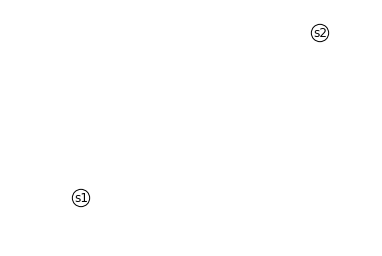

In [5]:
clusters, num_alignments = cluster([s1, s2], 0.70, 
                                   furthest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Now imagine that our third sequence, ``s3`` falls within the range of ``s1``. We'd cluster ``s3`` into ``OTU 1`` since it's within the similarity range of all of the sequences in ``OTU 1`` (for now that's just ``s1``). We now have three sequences clustered into two OTUs.

s1
Created OTU
s2
 OTU 1
   s1 0.5
Created OTU
s3
 OTU 1
   s1 0.8
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']


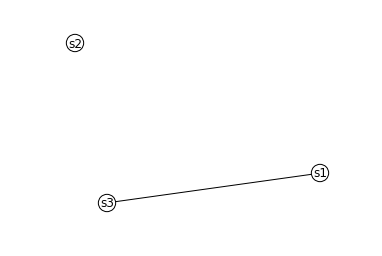

In [6]:
clusters, num_alignments = cluster([s1, s2, s3], 0.70, 
                                   furthest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Now let's cluster a fourth sequence, ``s4``. We find that this falls outside the range of ``OTU 1``, and also outside the range of ``OTU 2``. So, we'd create a new OTU, ``OTU 3``, containing ``s4``.

s1
Created OTU
s2
 OTU 1
   s1 0.5
Created OTU
s3
 OTU 1
   s1 0.8
Added to OTU
s4
 OTU 1
   s1 0.2
 OTU 2
   s2 0.5
Created OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']
OTU 3: ['s4']


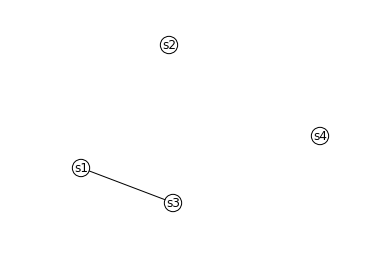

In [7]:
clusters, num_alignments = cluster([s1, s2, s3, s4], 0.70, 
                                   furthest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Next, let's cluster our fifth sequence, ``s5``. We find that this falls outside the range of ``OTU 1``, but inside the range of both ``OTU 2`` and ``OTU 3``. Algorithmically, we now have a choice to make. How do we decide which OTU a sequence should belong to if it is within the similarity range of several OTUs? 

A few choices would be:
 1. add it to the cluster where it first matches all sequences, 
 2. add it to the cluster where it has the smallest average distance to the cluster members, 
 3. or add it to the cluster with the most members. 

There are many other options as well. Let's choose the option 1 here, as it requires performing the fewest number of alignments, so should be fastest (we'll explore that in more detail soon). Our mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
   s1 0.5
Created OTU
s3
 OTU 1
   s1 0.8
Added to OTU
s4
 OTU 1
   s1 0.2
 OTU 2
   s2 0.5
Created OTU
s5
 OTU 1
   s1 0.4
 OTU 2
   s2 0.7
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2', 's5']
OTU 3: ['s4']


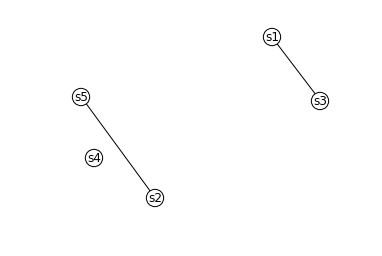

In [8]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5], 0.70, 
                                   furthest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Finally, let's cluster our last sequence, ``s6``. In this case, it falls within the similarity range of ``s1``, but outside of the similarity range of ``s3``. So, because our algortihm requires that a sequence be within the simiarity range of all sequences in an OTU, ``s6`` cannot be a member of ``OTU 1``, so instead it's assigned to a new OTU, ``OTU 4``. Our final mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
   s1 0.5
Created OTU
s3
 OTU 1
   s1 0.8
Added to OTU
s4
 OTU 1
   s1 0.2
 OTU 2
   s2 0.5
Created OTU
s5
 OTU 1
   s1 0.4
 OTU 2
   s2 0.7
Added to OTU
s6
 OTU 1
   s1 0.8
   s3 0.6
 OTU 2
   s5 0.4
 OTU 3
   s4 0.2
Created OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2', 's5']
OTU 3: ['s4']
OTU 4: ['s6']


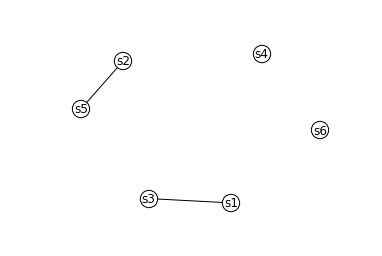

In [9]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5, s6], 0.70, 
                                   furthest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Let's apply that function to our real sequence collection.

In [10]:
clusters, num_alignments = cluster(seqs_16s, 0.70, furthest_neighbor)
show_clusters(clusters, plot_clusters=False, plot_labels=False)

OTU 1: ['1111689', '1106993', '579424', '579424', '512797', '512797', '512797', '166908', '166908', '166908', '166908', '155521', '155521', '155521', '155521', '155521', '111868', '111868', '111868', '111868', '111868', '111868', '18643', '18643', '18643', '18643', '18643', '18643', '18643', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388']
OTU 2: ['1108992', '521536', '248903', '248903', '2487129', '2487129', '2487129', '1118184', '1118184', '1118184', '1118184']
OTU 3: ['1106263', '552685']
OTU 4: ['1000658', '3973249']
OTU 5: ['859323', '836983', '699257', '699257', '559871', '559871', '559871', '559623', '559623', '559623', '559623', '240749', '240749', '240749', '240749', '240749', '2482760', '2482760', '2482760', '2482760', '2482760', '2

Let's define a function that will be useful for exploring different clustering algorithms:

In [11]:
from time import time

def evaluate_cluster_fn(cluster_fn, seqs, similarity_threshold, display=True):
    start_time = time()
    clusters, num_alignments = cluster(seqs, similarity_threshold, cluster_fn)
    end_time = time()
    run_time = end_time - start_time
    num_clusters = len(clusters)
    if display:
        print("Number of alignments performed: %d" % num_alignments)
        print("Runtime: %1.3fs" % run_time)
        print("Number of clusters: %d" % num_clusters)
        print("Clusters:")
        show_clusters(clusters, plot_clusters=False, plot_labels=False)
    return num_alignments, run_time, num_clusters

Now let's apply that:

In [12]:
r = evaluate_cluster_fn(furthest_neighbor, seqs_16s, 0.70)

Number of alignments performed: 1453
Runtime: 8.139s
Number of clusters: 36
Clusters:
OTU 1: ['1111689', '1106993', '579424', '579424', '512797', '512797', '512797', '166908', '166908', '166908', '166908', '155521', '155521', '155521', '155521', '155521', '111868', '111868', '111868', '111868', '111868', '111868', '18643', '18643', '18643', '18643', '18643', '18643', '18643', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '2311150', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '1125725', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388', '4484388']
OTU 2: ['1108992', '521536', '248903', '248903', '2487129', '2487129', '2487129', '1118184', '1118184', '1118184', '1118184']
OTU 3: ['1106263', '552685']
OTU 4: ['1000658', '3973249']
OTU 5: ['859323', '836983', '699257', '699257', '559871', '559871', '559871', '559623', '559623', '559623', '559623', '240749', '240749', '

### Nearest neighbor clustering

Let's try a variant on this algorithm. How would things change if **instead of requiring that a sequence be within the similarity treshold of all sequences in an OTU, we only required that it be within the similarity threshold of one sequence in that OTU**? This is referred to as **nearest neighbor** clustering, because cluster membership is defined by the percent similarity to the most similar (or *nearest*) "neighbor" in the cluster. 

Let's implement nearest neighbor clustering and look at the same six toy sequences as above.

In [13]:
def nearest_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    for node in cluster.nodes_iter():
        aln = aligner(seq, node)
        percent_similarity = aln[0].fraction_same(aln[1])
        alignment_results.append((node, percent_similarity))
        if verbose: print(" ", node.id, percent_similarity)
        if percent_similarity >= similarity_threshold:
            return True, alignment_results
    return False, alignment_results

In [14]:
print(aln1.to_fasta())

>s1
AAAAAAAAAA
>s2
AAAAATTTTT
>s3
AAAAAAACCA
>s4
CCCCAATTTT
>s5
ACCAAATTTT
>s6
AGGAAAAAAA



Our first sequence, ``s1``, will again define a new OTU, ``OTU 1``.

Our second sequence, ``s2``, still falls outside of the similarity threshold to ``s1``, so will define ``OTU 2``.

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
OTU 1: ['s1']
OTU 2: ['s2']


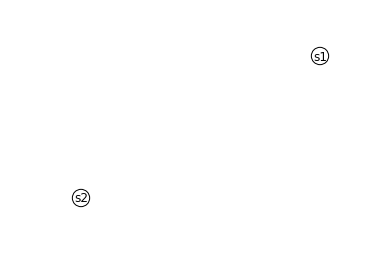

In [15]:
clusters, num_alignments = cluster([s1, s2], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Now imagine that our third sequence, $S3$ falls within the range of $OTU1$. We'd cluster $S3$ into $OTU1$ with $S1$. We now have three sequences clustered into two OTUs. So far, things are looking the same as before, except notice how our OTU definition (grey shading) is now different. Because any sequence within the similarity threshold of *any* of sequence in the OTU will fall into this OTU, the shading now covers the area covered by either of our sequences, rather than the area covered by both of our sequences (in set theory terminology, it is the *union* now, where previously it was the *intersection*). 

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']


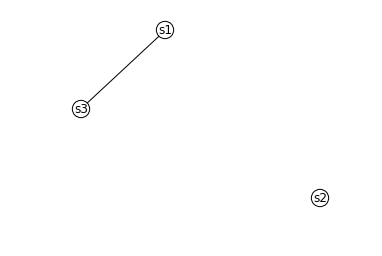

In [16]:
clusters, num_alignments = cluster([s1, s2, s3], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Now let's cluster a fourth sequence, $S4$. We find that this falls outside the range of $OTU1$, and also outside the range of $OTU2$. So, we'd create a new OTU, $OTU3$, containing $S4$.

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
  s3 0.2
 OTU 2
  s2 0.5
Created OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']
OTU 3: ['s4']


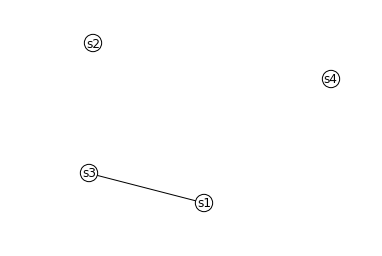

In [17]:
clusters, num_alignments = cluster([s1, s2, s3, s4], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Next, let's cluster our fifth sequence, $S5$. We find that this falls outside the range of $OTU1$, and inside the range of both $OTU2$ and $OTU3$. As with furthest neighbor, we have a choice of how to handle this. We'll again assign it to the first cluster that it match. Our mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
  s3 0.2
 OTU 2
  s2 0.5
Created OTU
s5
 OTU 1
  s1 0.4
  s3 0.4
 OTU 2
  s2 0.7
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2', 's5']
OTU 3: ['s4']


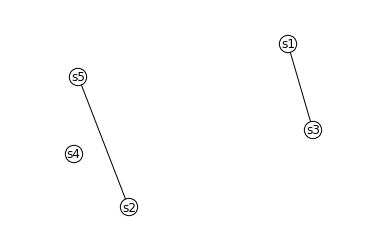

In [18]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Finally, let's cluster our last sequence, $S6$. Remember that $S6$ falls within the similarity range of $S1$, but outside of the similarity range of $S3$. In furthest neighbor, this meant that it was assigned to a new OTU, but with nearest neighbor it meets the inclusion criteria for $OTU1$. So, our final mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
  s3 0.2
 OTU 2
  s2 0.5
Created OTU
s5
 OTU 1
  s1 0.4
  s3 0.4
 OTU 2
  s2 0.7
Added to OTU
s6
 OTU 1
  s1 0.8
Added to OTU
OTU 1: ['s1', 's3', 's6']
OTU 2: ['s2', 's5']
OTU 3: ['s4']


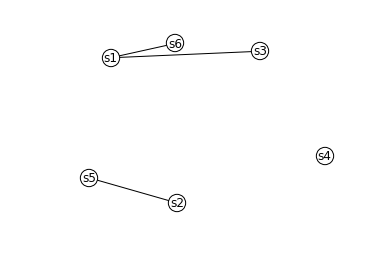

In [19]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5, s6], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

**One feature that becomes obvious here is the order dependence of these methods.** If sequences are provided in different order across different clustering runs, the cluster definitions will change. For example, how would the results differ if the sequences were processed in this order: $S1$, $S3$, $S4$, $S5$, $S6$, $S2$?

s1
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
  s3 0.2
Created OTU
s5
 OTU 1
  s1 0.4
  s3 0.4
 OTU 2
  s4 0.8
Added to OTU
s6
 OTU 1
  s1 0.8
Added to OTU
s2
 OTU 1
  s1 0.5
  s6 0.3
  s3 0.5
 OTU 2
  s5 0.7
Added to OTU
OTU 1: ['s1', 's3', 's6']
OTU 2: ['s4', 's5', 's2']


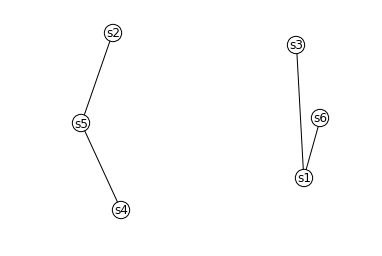

In [20]:
clusters, num_alignments = cluster([s1, s3, s4, s5, s6, s2], 0.70, 
                                   nearest_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Finally, let's apply this to our collection of real sequences again.

In [21]:
r = evaluate_cluster_fn(nearest_neighbor, seqs_16s, 0.70)

Number of alignments performed: 1067
Runtime: 6.317s
Number of clusters: 14
Clusters:
OTU 1: ['1111689', '1106993', '699257', '579424', '579424', '559871', '559871', '559623', '559623', '550168', '517495', '517495', '517495', '517495', '512797', '512695', '512695', '343047', '328298', '328298', '328298', '328298', '328298', '328298', '328298', '318949', '300487', '276077', '263415', '263415', '257203', '257203', '257203', '257203', '248903', '248903', '248903', '248903', '248903', '248903', '248903', '248903', '248903', '248903', '248903', '240749', '240749', '228077', '197535', '197535', '197535', '194270', '194270', '190312', '189899', '188920', '188920', '188920', '188920', '188850', '183532', '166908', '166908', '166908', '155521', '155521', '155521', '148618', '148618', '148618', '148618', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '142263', '112460', '112460', '112460', '112460', '111868', '111868', '111

You'll notice that both the runtime and the number of alignments performed here are different. Most of the runtime is spent aligning, so runtime and number of alignments should be strongly correlated.

There was another affect here though: we have a different number of OTUs. Is this result better or worse? There is not a definitive answer to that question: it really depends on the application, so what we'd ultimately want to know is how does that affect our ability to interpret the data. **Remember: OTU clustering is a necessary evil to deal with the massive amounts of data that we have. We don't necessary care about things like how many OTUs a method gives us, but rather how the clustering process helps or hurts us answer the biological questions driving the analysis.** We'll explore this concept more in later chapters, but it is an important one that algorithm developers sometimes lose track of.

### Centroid clustering

So, given that the number of alignments performed is correlated with runtime, are there ways that we can reduce the number of alignments that are computed by a clustering algorithm? One approach for that is generally referred to as **centroid clustering**. Here, we can say that **a sequence is assigned to an OTU if it is within the similarity threshold of the first sequence in that OTU**. The first sequence in that cluster then becomes the *cluster centroid*: cluster membership is defined by similarity to that one particular sequence, which effectively sits at the "center" of that OTU.

Let's implement this and apply the process to our six sequences.

In [22]:
def centroid_neighbor(seq, cluster, similarity_threshold, aligner, verbose=False):
    alignment_results = []
    centroid_node = cluster.graph['node-order'][0]
    aln = aligner(seq, centroid_node)
    percent_similarity = aln[0].fraction_same(aln[1])
    if verbose: print(" ", centroid_node.id, percent_similarity)
    alignment_results.append((centroid_node, percent_similarity))
    return percent_similarity >= similarity_threshold, alignment_results

``s1`` will again define ``OTU 1`` and ``s2`` still falls outside of the similarity threshold to ``s1``, so will define ``OTU 2``.

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
OTU 1: ['s1']
OTU 2: ['s2']


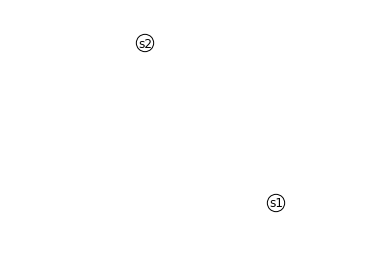

In [23]:
clusters, num_alignments = cluster([s1, s2], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Next, ``s3`` falls within the range of ``OTU 1``. We'd cluster ``s3`` into ``OTU 1`` with ``s1``, and now have three sequences clustered into two OTUs. Again, our sequence to OTU mapping looks the same as before at this stage.

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']


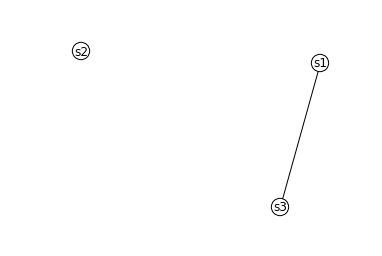

In [24]:
clusters, num_alignments = cluster([s1, s2, s3], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Now let's cluster a fourth sequence, $S4$. We find that this falls outside the range of $OTU1$, and (just barely) outside the range of $OTU2$. So, we'd create a new OTU, $OTU3$, containing $S4$.

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
 OTU 2
  s2 0.5
Created OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2']
OTU 3: ['s4']


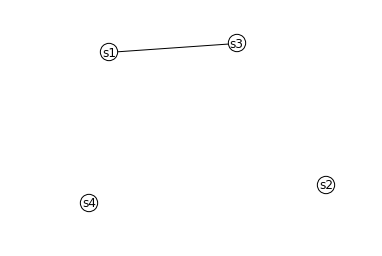

In [25]:
clusters, num_alignments = cluster([s1, s2, s3, s4], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Next, let's cluster our fifth sequence, $S5$. We find that this falls outside the range of $OTU1$, and inside the range of both $OTU2$ and $OTU3$. As with furthest neighbor, we have a choice of how to handle this. We'll again assign it to the cluster to which it is the most similar. Our mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
 OTU 2
  s2 0.5
Created OTU
s5
 OTU 1
  s1 0.4
 OTU 2
  s2 0.7
Added to OTU
OTU 1: ['s1', 's3']
OTU 2: ['s2', 's5']
OTU 3: ['s4']


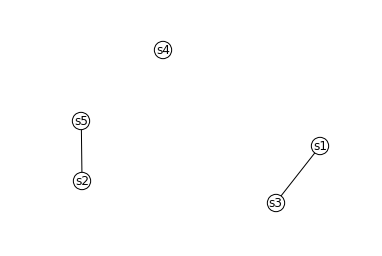

In [26]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Finally, let's cluster our last sequence, ``s6``. Remember that ``s6`` falls within the similarity range of ``s1``, but outside of the similarity range of ``s3``. In furthest neighbor, this meant that it was assigned to a new OTU; in nearest neighbor, it was assigned to ``OTU 1``, and that is what happens here. Our final mapping of OTUs to sequences would look like:

s1
Created OTU
s2
 OTU 1
  s1 0.5
Created OTU
s3
 OTU 1
  s1 0.8
Added to OTU
s4
 OTU 1
  s1 0.2
 OTU 2
  s2 0.5
Created OTU
s5
 OTU 1
  s1 0.4
 OTU 2
  s2 0.7
Added to OTU
s6
 OTU 1
  s1 0.8
Added to OTU
OTU 1: ['s1', 's3', 's6']
OTU 2: ['s2', 's5']
OTU 3: ['s4']


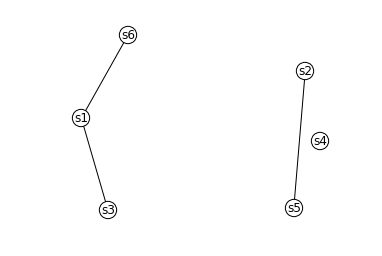

In [27]:
clusters, num_alignments = cluster([s1, s2, s3, s4, s5, s6], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

Again, let's think about order dependence here. How would this differ if ``s3`` was the centroid of ``OTU 1``, rather than ``s1``?

s3
Created OTU
s1
 OTU 1
  s3 0.8
Added to OTU
s2
 OTU 1
  s3 0.5
Created OTU
s4
 OTU 1
  s3 0.2
 OTU 2
  s2 0.5
Created OTU
s5
 OTU 1
  s3 0.4
 OTU 2
  s2 0.7
Added to OTU
s6
 OTU 1
  s3 0.6
 OTU 2
  s2 0.3
 OTU 3
  s4 0.2
Created OTU
OTU 1: ['s3', 's1']
OTU 2: ['s2', 's5']
OTU 3: ['s4']
OTU 4: ['s6']


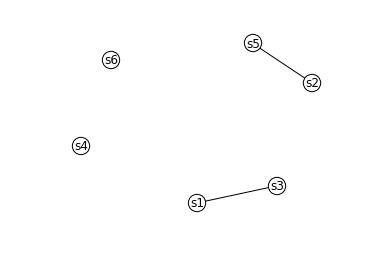

In [28]:
clusters, num_alignments = cluster([s3, s1, s2, s4, s5, s6], 0.70, 
                                   centroid_neighbor, aligner=global_pairwise_align_nucleotide, verbose=True)
show_clusters(clusters, plot_labels=True)

In [29]:
r = evaluate_cluster_fn(centroid_neighbor, seqs_16s, 0.70)

Number of alignments performed: 858
Runtime: 5.413s
Number of clusters: 25
Clusters:
OTU 1: ['1111689', '1106993', '699257', '579424', '512797', '328298', '166908', '155521', '111868', '18643', '2311150', '1125725', '4434069', '4484388']
OTU 2: ['1108992', '521536', '248903', '112460', '2487129', '798861', '1118184']
OTU 3: ['1106263', '552685']
OTU 4: ['1000658', '3973249']
OTU 5: ['859323', '836983', '559871', '559623', '550168', '240749', '109088', '2482760', '2950554', '686847', '4424907']
OTU 6: ['828305']
OTU 7: ['826813', '142263', '4307012', '4362975']
OTU 8: ['730163', '585540', '287788', '264676', '100923', '4318658']
OTU 9: ['586453', '343047', '318949', '276077', '263415', '197535', '194270', '190312', '189899', '188920', '188850', '183532', '2529078', '677148', '640392', '4130966', '4398028', '4405106']
OTU 10: ['581958', '515707', '2277614', '4298163']
OTU 11: ['520017', '108280']
OTU 12: ['517495', '512695', '300487']
OTU 13: ['257203', '228077', '737067', '4197922', '42

We've now reduced the number of alignments and the runtime. What was the effect on the results?

### Three different definitions of OTUs

With these three algorithms, we've looked at three different ways of defining a cluster or OTUs. This figure illustrates the differences in each definition, where the points illustrate sequences, the solid lines illustrated a similarity threshold, and the grey areas represent the space defining an OTU (or where a new sequence must fall to be considered part of an OTU).

<div style="float: right; margin-left: 30px;"><img style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/fundamentals/images/cluster-legend.png" align=right></div>

<div style="float: right; margin-left: 30px;"><img style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/fundamentals/images/cluster-types.png" align=right></div>

In furthest neighbor, where membership in a cluster is defined by a query sequence's distance to the most dissimilar sequence already in the cluster (its furthest neighbor), the definition of the cluster shrinks with additional sequences. This can have some undesired effects, such as the definition of a cluster becoming so restrictive that it is unlikely that new sequences will ever be added.

In nearest neighbor, where membership in a cluster is defined by a query sequence's distance to the most similar sequence already in the cluster (its nearest neighbor), the definition of the cluster can grow with additional sequences. This can have some undesired effects as well: in the worst case we could end up with one single cluster that contains all of our sequences.

In centroid distance, where membership in a cluster is defined by a query sequence's distance to the cluster's centroid sequence, the size of the cluster always remains the same, but the role that the first sequence added to a cluster plays becomes much more important. So, it's very important that the cluster centroids are well-chosen. One undesired effect of centroid distance cluster is that the cluster sizes are fixed, which may or may not always make biological sense (for example, if the marker gene evolves at a faster rate in some taxa than others, that can't be reflected in the cluster defintions. 

All of these methods have good features and bad features, and that in fact is a common feature of heuristics (if they were perfect, they wouldn't be heuristics after all...). 

## Comparing properties of our clustering algorithms

We so far looked at these algorithms based on a single similarity threshold and a single sequence collection, but as we know from previous chapters it's important to know how features such as run time change with different inputs. Let's explore these algorithms in the context of changing sequence collection sizes and similarity thresholds. 

To do this, we're going to do a *parameter sweep*. We're going to "sweep" over a bunch of different input parameters, and then explore how they affect our results. 

The parameters that we'll sweep over here are:
 * input sequences
 * similarity thresholds for sequence clustering
 * clustering methods
 * and number of sequences.

The outputs that we'll explore are:
 * number of alignments that were performed
 * run time
 * and number of resulting OTUs (or clusters). 

For the sake of runtime, I'm only looking at few settings for each of the input parameters. You may want to expand from there, but note that the number of combinations grows quickly since we're going to analyze all combinations of the parameters. For example, for our similarity threshold sweep, if we test two sequence collections, three similarity thresholds, and three clustering methods, we'd run $2 \times 3 \times 3 = 18$ clustering runs. If we add one more similarity threshold, that number would jump to $2 \times 4 \times 3 = 24$ clustering runs. So, these numbers can increase quickly.

In [30]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

n = 2
fraction_to_keep = 0.002
similarity_thresholds = [0.60, 0.70, 0.80]
cluster_fns = [("furthest neighbor", furthest_neighbor), 
               ("nearest neighbor", nearest_neighbor), 
               ("centroid neighbor", centroid_neighbor)]
sizes = [20, 30, 45]

def get_random_sequence_collection(input_seqs, fraction_to_keep):
    result = []
    for e in input_seqs:
        if random() < fraction_to_keep:
            result.append(BiologicalSequence(e[1], id=e[0]))
    return SequenceCollection(result)

data = []
# first, sweep over different random sequence collections
for i in range(n):
    random_sc = get_random_sequence_collection(parse_fasta(get_reference_sequences()),
                                               fraction_to_keep)
    # then, sweep over clustering functions
    for cluster_fn in cluster_fns:
        # then, sweep over data set sizes
        similarity_threshold = 0.70
        for size in sizes:
            current_sc = random_sc[:size]
            alignment_count, run_time, cluster_count = evaluate_cluster_fn(
                cluster_fn[1], current_sc, similarity_threshold, display=False)
            current_result = [cluster_fn[0], size, alignment_count, run_time, 
                              cluster_count, similarity_threshold]
            data.append(current_result)
        
        current_sc = random_sc[:sizes[-1]]
        # finally, sweep over similarity thresholds
        for similarity_threshold in similarity_thresholds:
            alignment_count, run_time, cluster_count = evaluate_cluster_fn(
                cluster_fn[1], current_sc, similarity_threshold, display=False)
            current_result = [cluster_fn[0], size, alignment_count, run_time, 
                              cluster_count, similarity_threshold]
            data.append(current_result)
df = pd.DataFrame(data, columns=["Cluster method", "Number of sequences", "Number of alignments", 
                                 "Run time (s)", "Number of clusters", "Similarity threshold"])

Remember that above I said that most of the time in each of these clustering algorithms is spent doing pairwise alignment. Let's plot the run time of each clustering method as a function of the number of alignments comptued in the cluster process so I can prove that to you.

Pearson r: 0.9986
Pearson p-value: 8.8861e-45


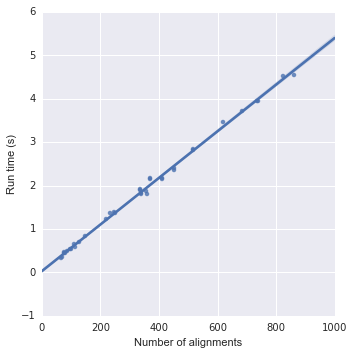

In [31]:
r, p = pearsonr(df["Number of alignments"], df["Run time (s)"])
print("Pearson r: %1.4f" % r)
print("Pearson p-value: %1.4e" % p)
sns.lmplot("Number of alignments", "Run time (s)", data=df)

Next, we can see how each of these methods scale with the similarity threshold.

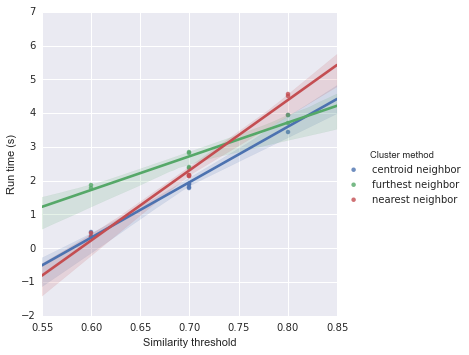

In [32]:
g = sns.lmplot("Similarity threshold", "Run time (s)", 
               hue="Cluster method",
               data=df[df["Number of sequences"] == max(sizes)])

Next let's look at run time as a function of the number of sequences to be clustered.

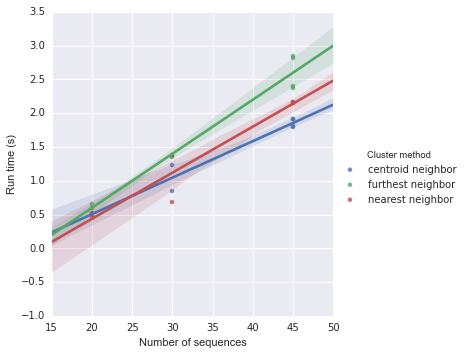

In [33]:
g = sns.lmplot("Number of sequences", "Run time (s)", 
               hue="Cluster method",
               data=df[df['Similarity threshold'] == 0.70])

**Which of these methods do you think will scale best** to continuosuly increasing numbers of sequences (e.g., as is currently the trend in microbiomics)?

Finally, let's look at the number of clusters (or OTUs) that are generated with each method at each similarity threshold.

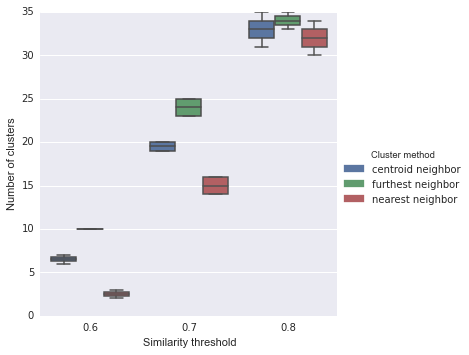

In [34]:
g = sns.factorplot("Similarity threshold", "Number of clusters",
                   "Cluster method", df[df["Number of sequences"] == max(sizes)],
                   kind="box")

## Reference-based clustering to assist with parallelization

Up until this point we have focused our discussion on *de novo* OTU clustering, meaning that sequences are clustered only against each other, with no external reference. This is a very widely applied protocol, and the primary function of popular bioinformatics tools such as [cdhit](http://bioinformatics.oxfordjournals.org/content/28/23/3150.long) and [uclust](http://bioinformatics.oxfordjournals.org/content/26/19/2460.long). Another category of OTU clustering protocols is also popular however: reference-based OTU clustering, where a external reference database of sequences is used to aid in cluster defintion.  

Reference-based clustering is typically a centroid-based approach, where cluster centroids are pre-defined based on sequences in a database. From here, reference-based clustering is performed in one of two ways. In *closed-reference* OTU clustering, the set of centroids is static, and sequenences that don't match a centroid are not clustered. In *open-reference* OTU clustering, the set of centroids can expand: sequences that don't match an existing centroid can become new centroid sequences. 

I plan to expand discussion of these topics in IAB (you can track progress on that in [issue #113](https://github.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/issues/113). In the meantime, [Rideout et al., (2014)](https://peerj.com/articles/545/) explains these concepts in detail.
